In [101]:
import importlib
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import tqdm
import soundfile as sf

import utils
import filters
import modules

importlib.reload(utils)
importlib.reload(filters)
importlib.reload(modules)

device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

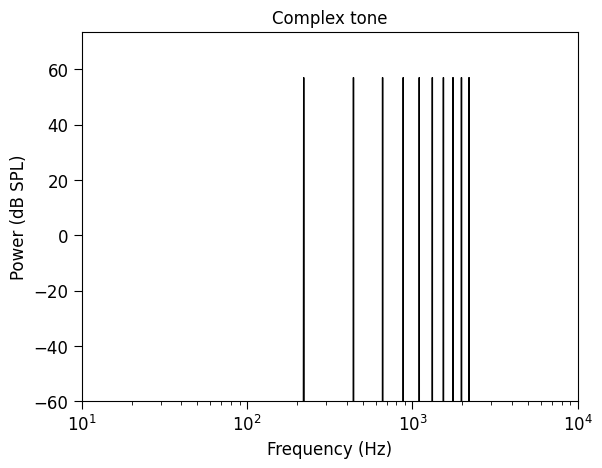

In [102]:
sr = 20e3
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.5,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 11),
    amplitudes=0.02,
)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x, sr=sr, scaling="spectrum")
ax.plot(fxx, pxx, color="k", lw=1)
utils.format_axes(
    ax,
    str_title="Complex tone",
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
    xscale="log",
    yscale="linear",
    xlimits=[10, sr / 2],
    ylimits=[-60, None],
)
plt.show()

# fig, ax = utils.make_periodogram_plot(x, sr, str_title="Complex tone")

ipd.display(ipd.Audio(rate=sr, data=x))


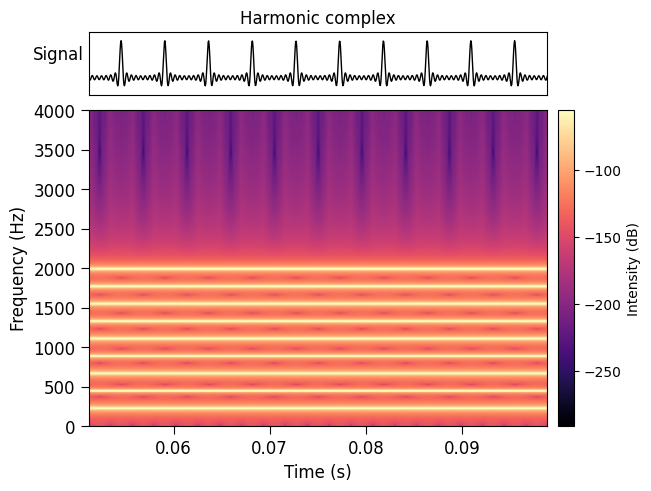

In [103]:
sr = 20e3
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.15,
    f0=220,
    phase="cosine",
    harmonics=np.arange(1, 10),
)
x = utils.set_dbspl(x, 60)
# x += utils.set_dbspl(np.random.randn(*x.shape), 45)

utils.make_spectrogram_plot(
    x,
    sr,
    nfft=2048,
    ylimits=[0, 4e3],
    str_title="Harmonic complex",
)
plt.show()


/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/modules.py:248: RuntimeWarning: divide by zero encountered in log
  filters = np.zeros((self.cf_num, len(f)), dtype=f.dtype)
/rdma/vast-rdma/vast/mcdermott/msaddler/coursework/auditory_model_tutorial/utils.py:99: RuntimeWarning: divide by zero encountered in log10
  pxx = 10.0 * np.log10(pxx / np.square(p_ref))


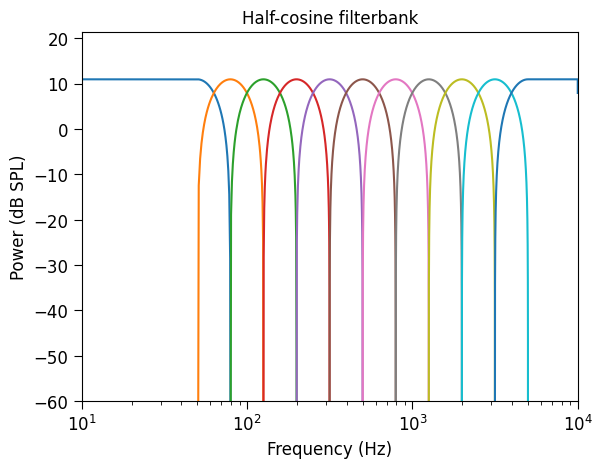

In [104]:
sr = 20e3
filterbank = modules.HalfCosineFilterbank(
    sr=sr,
    cf_low=5e1,
    cf_high=5e3,
    cf_num=11,
    scale="log",
    include_highpass=True,
    include_lowpass=True,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Half-cosine filterbank",
)
plt.show()


(50, 20000)


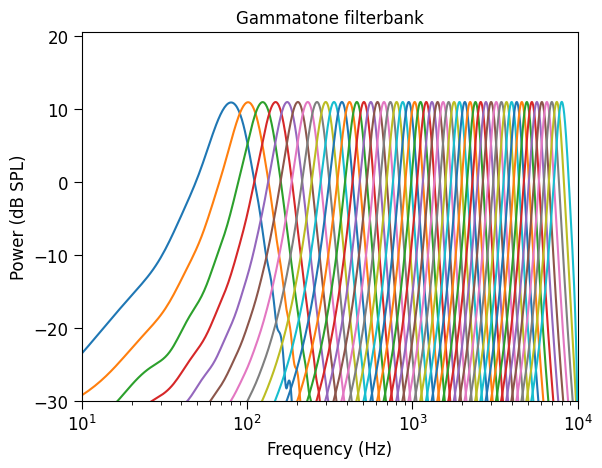

In [105]:
sr = 20e3
filterbank = modules.GammatoneFilterbank(
    sr=sr,
    fir_dur=0.05,
    cfs=utils.erbspace(8e1, 8e3, 50),
    dtype=torch.float32,
    bw_mult=1,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Gammatone filterbank",
    ylimits=[-30, None],
)
plt.show()


(20000,)


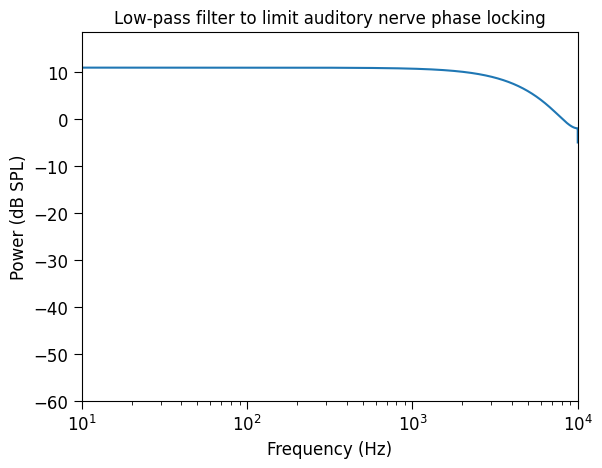

In [106]:
sr = 20e3
filterbank = modules.IHCLowpassFilter(
    sr_input=sr,
    sr_output=sr,
    fir_dur=0.05,
    cutoff=3e3,
    order=7,
).to(device)

impulse = np.zeros(int(sr * 1.0))
impulse[0] = 1.0
impulse_tensor = torch.as_tensor(impulse, device=device).float().unsqueeze(0)
impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
impulse_response = impulse_response_tensor.detach().cpu().numpy()
print(impulse_response.shape)

fig, ax = utils.make_periodogram_plot(
    impulse_response,
    sr,
    str_title="Low-pass filter to limit auditory nerve phase locking",
)
plt.show()


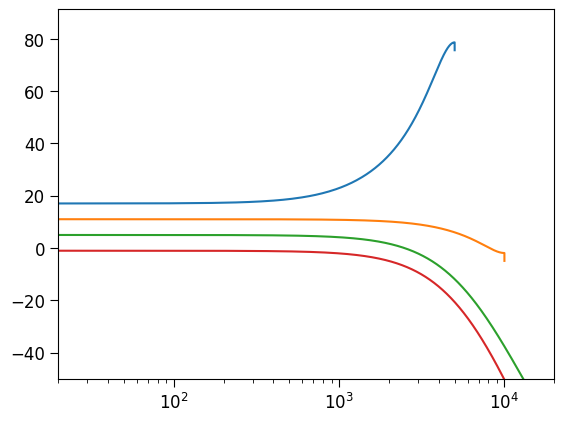

In [107]:
fig, ax = plt.subplots()

for sr in [10e3, 20e3, 40e3, 80e3]:
    filterbank = modules.IHCLowpassFilter(
        sr_input=sr,
        sr_output=sr,
        fir_dur=0.05,
        cutoff=3e3,
        order=7,
    ).to(device)
    impulse = np.zeros(int(sr * 1.0))
    impulse[0] = 1.0
    impulse_tensor = torch.as_tensor(impulse, device=device).float().unsqueeze(0)
    impulse_response_tensor = filterbank(impulse_tensor).squeeze(0)
    impulse_response = impulse_response_tensor.detach().cpu().numpy()
    fxx, pxx = utils.periodogram(impulse_response, sr)
    ax.plot(fxx, pxx)

utils.format_axes(
    ax,
    xscale="log",
    xlimits=[20, 20e3],
    ylimits=[-50, None],
)
plt.show()


(500, 500)


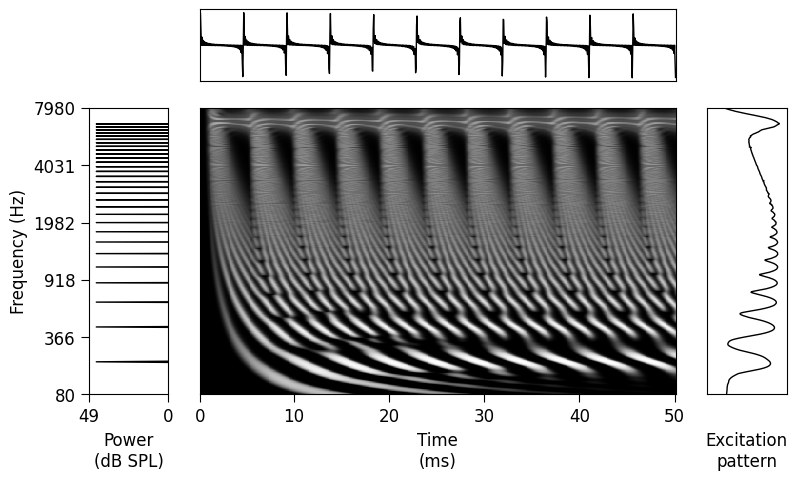

In [108]:
importlib.reload(utils)
importlib.reload(modules)

class CochlearModel(torch.nn.Module):
    def __init__(
        self,
        sr_input=20000,
        sr_output=10000,
        cfs=utils.erbspace(8e1, 8e3, 100),
        fir_dur=0.05,
        compression_power=0.3,
        threshold=12.0,
        bw_mult=1.0,
    ):
        """
        Simple cochlear model.

        Args
        ----
        sr_input (int): sampling rate of the input sound waveform
        sr_output (int): sampling rate of the output representation
        cfs (np.ndarray): characteristic frequencies of the cochlear filters
        fir_dur (float): duration of the filter FIRs in seconds
        compression_power (float): power of the compression applied to filterbank outputs
        threshold (float): absolute threshold in dB SPL of auditory nerve fibers
        bw_mult (float): scales cochlear filter bandwidths
        """
        super().__init__()
        self.sr_input = sr_input
        self.sr_output = sr_output
        self.cfs = cfs
        self.cochlear_filterbank = modules.GammatoneFilterbank(
            sr=sr_input,
            fir_dur=fir_dur,
            cfs=self.cfs,
            dtype=torch.float32,
            bw_mult=bw_mult,
        )
        self.rate_level_function = modules.SigmoidRateLevelFunction(
            compression_power=compression_power,
            threshold=threshold,
        )
        self.ihc_lowpass_filter = modules.IHCLowpassFilter(
            sr_input=sr_input,
            sr_output=sr_output,
            fir_dur=fir_dur,
            cutoff=1e3,
            order=7,
        )

    def forward(self, x):
        """
        Run the cochlear model on an input sound waveform.

        Args
        ----
        x (torch.Tensor): input sound waveform with shape [batch_size, num_samples]

        Returns
        -------
        x (torch.Tensor): output of cochlear model with shape [batch_size, frequency_channels, num_samples]
        """
        x = self.cochlear_filterbank(x)
        x = torch.nn.functional.relu(x)
        x = self.rate_level_function(x)
        x = self.ihc_lowpass_filter(x)
        x = torch.nn.functional.relu(x)
        return x


sr = 20e3
cfs = utils.erbspace(8e1, 8e3, 500)
compression_power = np.ones_like(cfs) * 0.3
bw_mult = np.ones_like(cfs) * 1
cochlear_model = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    compression_power=compression_power,
    bw_mult=bw_mult,
).to(device)

x = utils.harmonic_complex_tone(
    sr=cochlear_model.sr_input,
    dur=0.05,
    f0=220,
    phase="sine",
    harmonics=np.arange(1, 31, 1),
)
x = utils.set_dbspl(x, 60)

x_tensor = torch.as_tensor(x, device=device).float().unsqueeze(0)
x_nervegram_tensor = cochlear_model(x_tensor).squeeze(0)
x_nervegram = x_nervegram_tensor.detach().cpu().numpy()
print(x_nervegram.shape)

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x,
    nervegram=x_nervegram,
    sr_waveform=cochlear_model.sr_input,
    sr_nervegram=cochlear_model.sr_output,
    cfs=cochlear_model.cfs,
)
plt.show()


In [109]:
for _ in tqdm.tqdm(range(100)):
    cochlear_model(x_tensor).squeeze(0)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2114.52it/s]


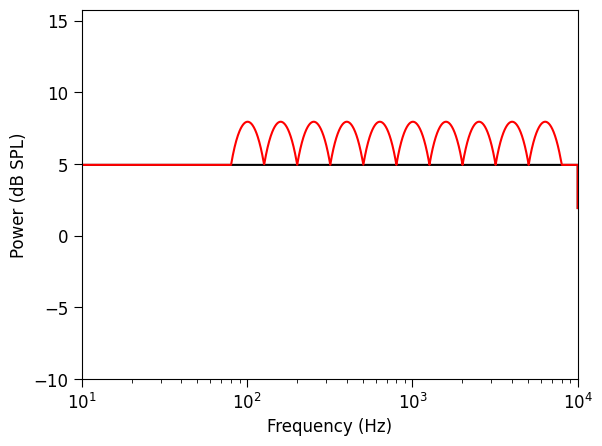

In [171]:
importlib.reload(modules)

class HearingAid(torch.nn.Module):
    def __init__(self, sr=20e3):
        super().__init__()
        self.filterbank = modules.HalfCosineFilterbank(
            sr=sr,
            cf_low=80,
            cf_high=8000,
            cf_num=11,
            scale="log",
            include_highpass=True,
            include_lowpass=True,
        )
        self.gains = torch.nn.parameter.Parameter(
            data=torch.zeros(self.filterbank.cf_num),
            requires_grad=True,
        )

    def forward(self, x):
        y = self.filterbank(x)
        y = y * torch.pow(10, self.gains / 20).view(1, -1, 1)
        y = torch.sum(y, axis=1)
        return y


# class HearingAid(torch.nn.Module):
#     def __init__(self, sr=20e3):
#         super().__init__()
#         self.conv = modules.AudioConv1d(
#             in_channels=1,
#             out_channels=1,
#             kernel_size=None,
#             sr=sr,
#             fir_dur=0.1,
#         )

#     def forward(self, x):
#         return self.conv(x[:, None, :])[:, 0, :]


sr = 20e3
hearing_aid = HearingAid(sr=sr)

x = torch.zeros(1, int(sr * 2))
x[:, 0] = 1
y = hearing_aid(x)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x[0].detach().cpu().numpy(), sr)
fyy, pyy = utils.periodogram(y[0].detach().cpu().numpy(), sr)
ax.plot(fxx, pxx, "k")
ax.plot(fyy, pyy, "r")
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[-10, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
)
plt.show()


In [172]:
cfs = utils.erbspace(8e1, 8e3, 100)

healthy_cochlear_model = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    compression_power=0.3,
    bw_mult=1.0,
    threshold=12.0
).to(device)

impaired_cochlear_model = CochlearModel(
    sr_input=sr,
    cfs=cfs,
    compression_power=0.3,
    bw_mult=1.0,
    # threshold=-12.0,
    # threshold=np.linspace(-12, 36, 100),
    threshold=np.array(([0] * 50) + ([24] * (len(cfs) - 50))),
).to(device)

def loss_function(x_healthy, x_impaired):
    y_healthy = healthy_cochlear_model(x_healthy)
    y_impaired = impaired_cochlear_model(x_impaired)
    loss = torch.nn.functional.mse_loss(y_impaired, y_healthy)
    # loss = torch.nn.functional.l1_loss(y_impaired, y_healthy)
    return loss

hearing_aid = HearingAid(sr=sr).to(device)
for n, p in hearing_aid.named_parameters():
    print(n, p.shape, p.dtype, p.device)


gains torch.Size([11]) torch.float32 cuda:0


In [173]:
for n, p in hearing_aid.named_parameters():
    print(n, p if p.ndim == 1 else p.shape)


x = np.stack(
    [sf.read("data/{:03d}.wav".format(_))[0] for _ in range(4)],
    axis=0,
)

# x, _ = sf.read("data/000.wav")
x = torch.as_tensor(x, device=device, dtype=torch.float32)
# x = x[None, 10000:15000]
# x = x[None, :]
# torch.manual_seed(0)
# x = torch.randn(1, 500, device=device)
print(x.shape)

with torch.autograd.set_detect_anomaly(False):
    num_steps = 500
    optimizer = torch.optim.Adam(
        params=list(hearing_aid.parameters()),
        lr=1e-1,
    )
    pbar = tqdm.tqdm(range(num_steps))
    for step in pbar:
        # x = utils.harmonic_complex_tone(
        #     sr=sr,
        #     dur=0.05,
        #     f0=220,
        #     phase="sine",
        #     harmonics=np.arange(1, 41),
        # )
        # x = utils.set_dbspl(x, 60.0)
        # x = torch.as_tensor(x[None, ...], dtype=torch.float32)

        # x = torch.randn(32, 500, device=device)

        optimizer.zero_grad()
        x_hearing_aid = hearing_aid(x)
        loss = loss_function(x_healthy=x, x_impaired=x_hearing_aid)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"loss": "{:0.4f}".format(loss.item())})

for n, p in hearing_aid.named_parameters():
    print(n, p if p.ndim == 1 else p.shape)


gains Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)
torch.Size([4, 40000])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:28<00:00, 17.46it/s, loss=74.4182]

gains Parameter containing:
tensor([-15.7123, -13.8562, -14.3010, -14.6555, -14.0600, -14.4658, -12.8977,
         12.0310,   9.2488,   9.8081,  10.1340], device='cuda:0',
       requires_grad=True)


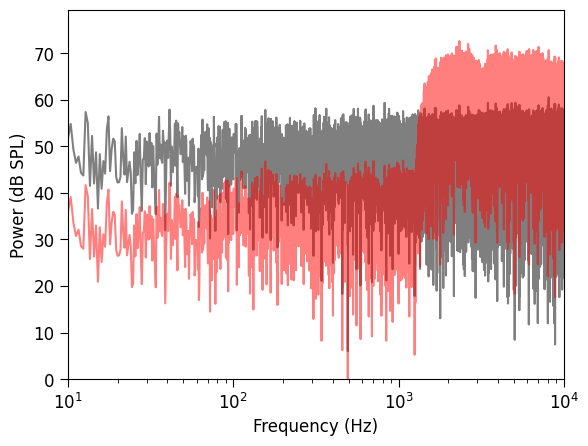

In [174]:
x = torch.randn(1, 50000, device=device)
y = hearing_aid(x)

fig, ax = plt.subplots()
fxx, pxx = utils.periodogram(x[0].detach().cpu().numpy(), sr)
fyy, pyy = utils.periodogram(y[0].detach().cpu().numpy(), sr)
ax.plot(fxx, pxx, "k", alpha=0.5)
ax.plot(fyy, pyy, "r", alpha=0.5)
utils.format_axes(
    ax,
    xscale="log",
    xlimits=[10, sr / 2],
    ylimits=[0, None],
    str_xlabel="Frequency (Hz)",
    str_ylabel="Power (dB SPL)",
)
plt.show()

ipd.display(ipd.Audio(rate=sr, data=x[0].detach().cpu().numpy()))
ipd.display(ipd.Audio(rate=sr, data=y[0].detach().cpu().numpy()))


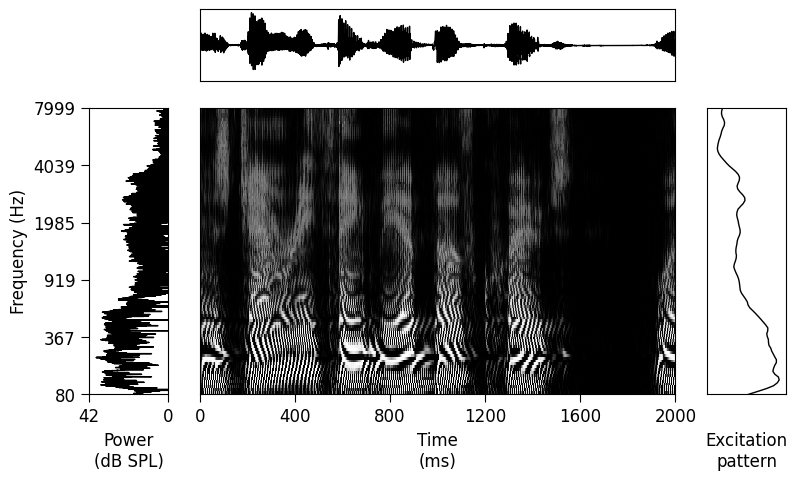

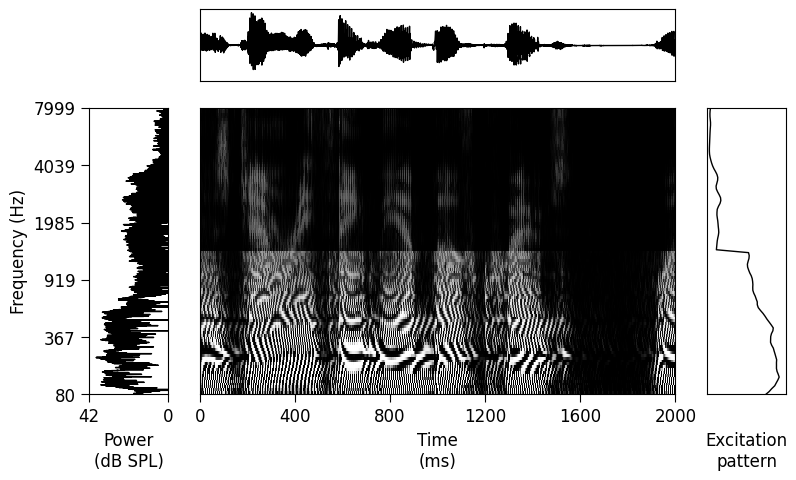

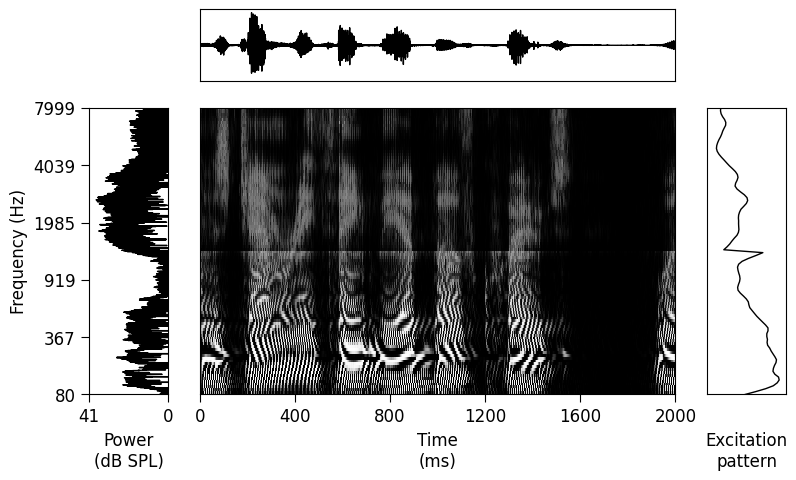

In [175]:
x = utils.harmonic_complex_tone(
    sr=sr,
    dur=0.05,
    f0=175,
    phase="sine",
    harmonics=np.arange(1, 41),
)
# x = np.random.randn(10000)
x = utils.set_dbspl(x, 60.0)
x, _ = sf.read("data/000.wav")
x = torch.as_tensor(x[None, ...], dtype=torch.float32, device=device)
x_aided = hearing_aid(x)


nervegram_x = healthy_cochlear_model(x)[0].detach().cpu().numpy()
nervegram_x_aided = healthy_cochlear_model(x_aided)[0].detach().cpu().numpy()
nervegram_x_impaired = impaired_cochlear_model(x)[0].detach().cpu().numpy()
nervegram_x_impaired_aided = impaired_cochlear_model(x_aided)[0].detach().cpu().numpy()

# fig, ax_arr = utils.make_nervegram_plot(
#     waveform=x_aided[0].detach().cpu().numpy(),
#     nervegram=nervegram_x - nervegram_x_impaired,
#     sr_waveform=healthy_cochlear_model.sr_input,
#     sr_nervegram=healthy_cochlear_model.sr_output,
#     cfs=healthy_cochlear_model.cfs,
# )
# fig, ax_arr = utils.make_nervegram_plot(
#     waveform=x_aided[0].detach().cpu().numpy(),
#     nervegram=nervegram_x - nervegram_x_impaired_aided,
#     sr_waveform=healthy_cochlear_model.sr_input,
#     sr_nervegram=healthy_cochlear_model.sr_output,
#     cfs=healthy_cochlear_model.cfs,
# )

fig, ax_arr = utils.make_nervegram_plot(
    waveform=x[0].detach().cpu().numpy(),
    nervegram=nervegram_x,
    sr_waveform=healthy_cochlear_model.sr_input,
    sr_nervegram=healthy_cochlear_model.sr_output,
    cfs=healthy_cochlear_model.cfs,
)
# fig, ax_arr = utils.make_nervegram_plot(
#     waveform=x_aided[0].detach().cpu().numpy(),
#     nervegram=nervegram_x_aided,
#     sr_waveform=healthy_cochlear_model.sr_input,
#     sr_nervegram=healthy_cochlear_model.sr_output,
#     cfs=healthy_cochlear_model.cfs,
# )
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x[0].detach().cpu().numpy(),
    nervegram=nervegram_x_impaired,
    sr_waveform=healthy_cochlear_model.sr_input,
    sr_nervegram=healthy_cochlear_model.sr_output,
    cfs=healthy_cochlear_model.cfs,
)
fig, ax_arr = utils.make_nervegram_plot(
    waveform=x_aided[0].detach().cpu().numpy(),
    nervegram=nervegram_x_impaired_aided,
    sr_waveform=healthy_cochlear_model.sr_input,
    sr_nervegram=healthy_cochlear_model.sr_output,
    cfs=healthy_cochlear_model.cfs,
)
plt.show()


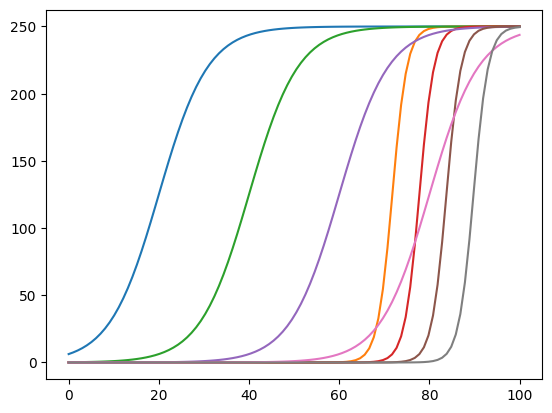

In [176]:
fig, ax = plt.subplots()
for threshold in [0, 20, 40, 60]:
    for compression_power in [0.3, 1.0]:
        layer = modules.SigmoidRateLevelFunction(threshold=threshold, compression_power=compression_power)
        x_db = torch.linspace(0, 100, 100)
        x = 20e-6 * (10 ** (x_db / 20))
        y = layer(x[None, None, :])[0, 0, :]
        ax.plot(x_db.numpy(), y.numpy())
plt.show()


In [ ]:
fn = "/om2/user/msaddler/phaselocknet/stimuli/spkr_word_recognition/evaluation/human_experiment_v00_foreground60dbspl/stim.hdf5"

import h5py
with h5py.File(fn, "r") as f:
    list_idx = np.logical_and.reduce(
        [
            np.isinf(f["snr"][:]),
            f["background_condition"][:] == 0,
        ],
    )
    list_idx = np.argwhere(list_idx).reshape([-1])
    for idx in tqdm.tqdm(list_idx):
        y = f["signal"][idx]
        sr = f["sr"][idx]
        foreground_index = f["foreground_index"][idx]
        fn_wav = "data/{:03.0f}.wav".format(foreground_index)
        sf.write(
            file=fn_wav,
            data=y,
            samplerate=sr,
        )
